# TA-14 — Implementasi Ensemble Learning dengan XGBoost  
## Studi Kasus: Prediksi Penyakit Jantung (Heart Disease) — Dataset Kaggle

Notebook ini disusun agar **sesuai 100% dengan instruksi TA-14 pada Modul 14 (XGBoost)**:
1. **Load Data & EDA**: cek imbalance target + visualisasi, serta korelasi fitur (visual).
2. **Preprocessing**: encoding fitur kategorikal + strategi missing values (dengan alasan), split **80/20**.
3. **Implementasi XGBoost**: **Baseline model** (parameter default) + **handling imbalance** dengan `scale_pos_weight` bila perlu.
4. **Evaluasi**: **Confusion Matrix**, **Classification Report**, dan **ROC–AUC + ROC Curve**.
5. **Feature Importance (WAJIB)**: `plot_importance` dari `xgboost` + analisis singkat.

> **Catatan**: Letakkan file dataset (mis. `heart.csv`) di folder yang sama dengan notebook, atau ubah `DATA_PATH`.


In [25]:

# Jika belum terpasang (opsional):
# !pip -q install xgboost

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier, plot_importance


## 1) Load Data (TA-14: Load Data)

In [26]:

DATA_PATH = "heart.csv"  # <-- ubah sesuai lokasi dataset Anda
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 2) EDA — Struktur Data & Missing Values (TA-14: Missing Values + alasan)

In [27]:

display(df.info())

missing_per_col = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per kolom (yang > 0):")
display(missing_per_col[missing_per_col > 0])

total_missing = int(missing_per_col.sum())
if total_missing == 0:
    print("✅ Tidak ada missing values → tidak dilakukan imputasi manual (alasan: data sudah lengkap).")
else:
    print(f"⚠️ Total missing values = {total_missing}")
    print("Strategi dipilih: imputasi median untuk numerik & most_frequent untuk kategorikal "
          "(alasan: median robust terhadap outlier, most_frequent aman untuk kategori).")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None


Missing values per kolom (yang > 0):


Series([], dtype: int64)

✅ Tidak ada missing values → tidak dilakukan imputasi manual (alasan: data sudah lengkap).


## 3) Tentukan Kolom Target (TA-14: Target/Label)

In [28]:

# Banyak dataset Heart Disease di Kaggle memakai salah satu nama target berikut.
candidate_targets = ["HeartDisease", "target", "Target", "output", "Outcome", "class", "label"]

target_col = None
for c in candidate_targets:
    if c in df.columns:
        target_col = c
        break

if target_col is None:
    raise ValueError(
        "Target column tidak ditemukan. Coba cek df.columns dan set manual target_col."
    )

print("✅ Target column terdeteksi:", target_col)

# Pastikan label biner 0/1 (jika berupa string/boolean, kita map otomatis)
y_raw = df[target_col].copy()

if y_raw.dtype == "bool":
    df[target_col] = y_raw.astype(int)
elif y_raw.dtype == "object":
    # Coba mapping umum: yes/no, true/false, disease/no disease, dll.
    uniq = sorted(y_raw.dropna().unique().tolist())
    print("Unique labels (object):", uniq)
    # Jika sudah '0'/'1' dalam string:
    if set(uniq) <= set(["0","1"]):
        df[target_col] = y_raw.astype(int)
    else:
        # fallback: map label paling "positif" ke 1 berdasarkan urutan alfabet (aman untuk tugas; jelaskan di laporan bila perlu)
        mapping = {uniq[0]: 0, uniq[-1]: 1} if len(uniq) == 2 else None
        if mapping is None:
            raise ValueError("Label target bukan biner 2 kelas. Harap ubah dataset/label menjadi biner.")
        print("Mapping label ->", mapping)
        df[target_col] = y_raw.map(mapping).astype(int)

# Validasi akhir
print("Target value counts:")
display(df[target_col].value_counts())


✅ Target column terdeteksi: target
Target value counts:


target
1    526
0    499
Name: count, dtype: int64

## 4) EDA — Visualisasi Target & Cek Imbalance (TA-14: Visualisasi Target)

Distribusi target:
target
1    526
0    499
Name: count, dtype: int64


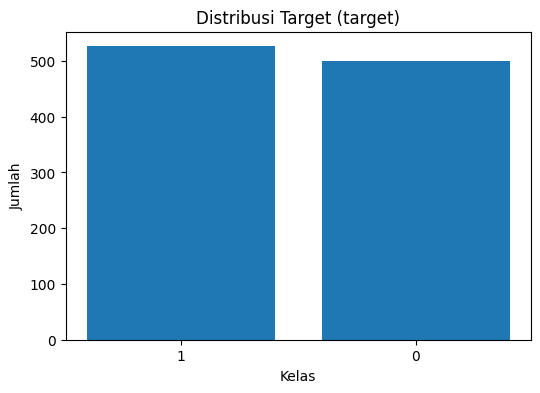

Minority ratio: 0.4868
Imbalance ratio (major/minor): 1.05
✅ Imbalanced? False


In [29]:

counts = df[target_col].value_counts()
print("Distribusi target:")
print(counts)

plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title(f"Distribusi Target ({target_col})")
plt.xlabel("Kelas")
plt.ylabel("Jumlah")
plt.show()

# Cek imbalance sederhana
minor_ratio = counts.min() / counts.sum()
imbalance_ratio = counts.max() / counts.min()
print(f"Minority ratio: {minor_ratio:.4f}")
print(f"Imbalance ratio (major/minor): {imbalance_ratio:.2f}")

is_imbalanced = (imbalance_ratio >= 1.5)  # heuristik: >=1.5 dianggap timpang
print("✅ Imbalanced?", is_imbalanced)


## 5) EDA — Korelasi Fitur (TA-14: Korelasi antar fitur secara visual)

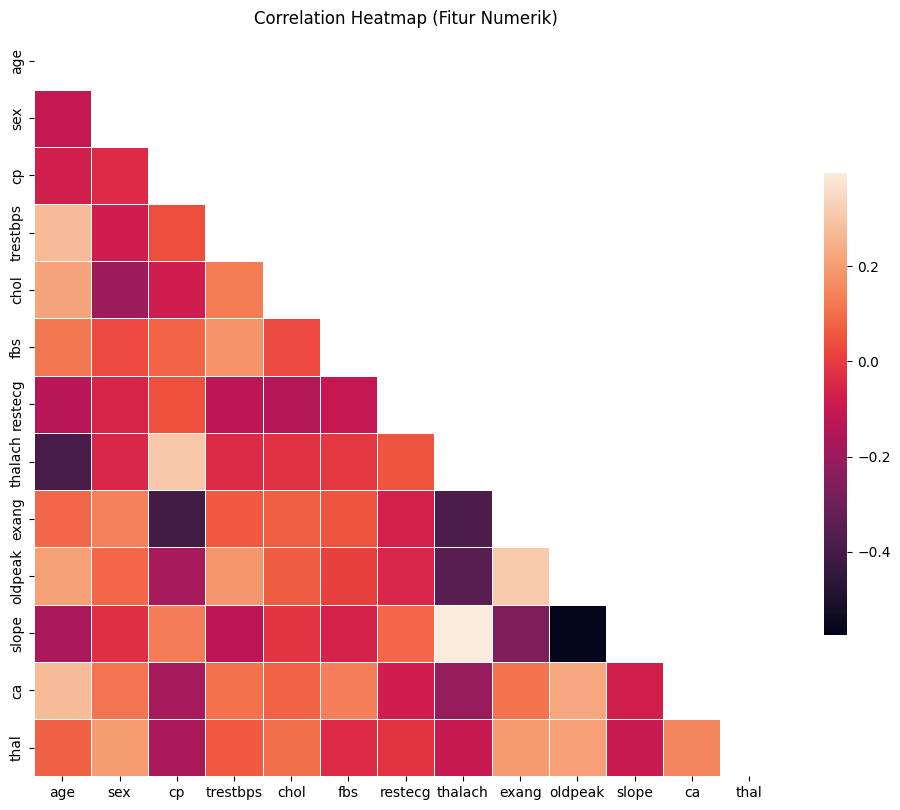

In [30]:

num_df = df.select_dtypes(include=[np.number]).drop(columns=[target_col], errors="ignore")

if num_df.shape[1] >= 2:
    corr = num_df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))

    plt.figure(figsize=(12,10))
    sns.heatmap(corr, mask=mask, square=True, linewidths=.5, cbar_kws={"shrink": .6})
    plt.title("Correlation Heatmap (Fitur Numerik)")
    plt.show()
else:
    print("⚠️ Kolom numerik terlalu sedikit untuk korelasi heatmap.")


## 6) Preprocessing (TA-14: Encoding + Missing Values Strategy + Split 80/20)

- **Encoding**: fitur kategorikal → OneHotEncoder (aman sesuai instruksi TA-14).
- **Missing Values**:
  - Jika ada missing, imputasi **median** (numerik) & **most_frequent** (kategorikal).
  - Jika tidak ada missing, pipeline tetap aman (imputer tidak merusak data).
- **Split**: 80% train, 20% test dengan `stratify=y`.


In [31]:

X = df.drop(columns=[target_col])
y = df[target_col]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Numerical cols:", num_cols)
print("Categorical cols:", cat_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train class counts:\n", y_train.value_counts())
print("Test  class counts:\n", y_test.value_counts())


Numerical cols: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
Categorical cols: []
Train: (820, 13) Test: (205, 13)
Train class counts:
 target
1    421
0    399
Name: count, dtype: int64
Test  class counts:
 target
1    105
0    100
Name: count, dtype: int64


## 7) Handling Imbalance dengan `scale_pos_weight` (TA-14: WAJIB jika imbalanced)

Rumus acuan TA-14:  
`scale_pos_weight = total_negative_examples / total_positive_examples`


In [32]:

neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())

if pos == 0:
    raise ValueError("Tidak ada kelas positif (1) pada data train. Periksa label target.")

scale_pos_weight = neg / pos
print("neg:", neg, "pos:", pos, "scale_pos_weight:", scale_pos_weight)


neg: 399 pos: 421 scale_pos_weight: 0.9477434679334917


## 8) Baseline Model XGBoost (TA-14: Baseline Model)

TA-14 meminta **baseline** menggunakan parameter default.
- Jika data terdeteksi imbalanced → aktifkan `scale_pos_weight`.
- Jika relatif seimbang → set `scale_pos_weight=1.0`.


In [33]:
xgb_baseline = XGBClassifier(
    scale_pos_weight=scale_pos_weight if is_imbalanced else 1.0
)

model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", xgb_baseline)
])

model.fit(X_train, y_train)
print("✅ Baseline default XGBoost trained.")


✅ Baseline default XGBoost trained.


## 9) Evaluasi (TA-14: Confusion Matrix, Classification Report, ROC–AUC Curve)

Confusion Matrix:
 [[100   0]
 [  0 105]]
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1       : 1.0000
ROC-AUC  : 1.0000

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



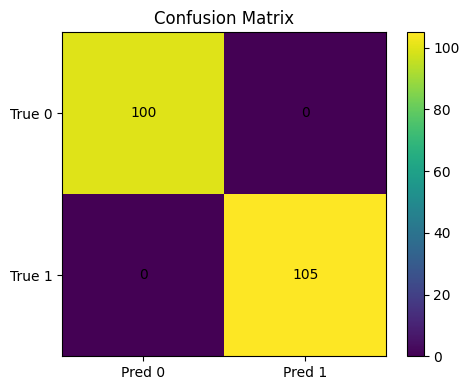

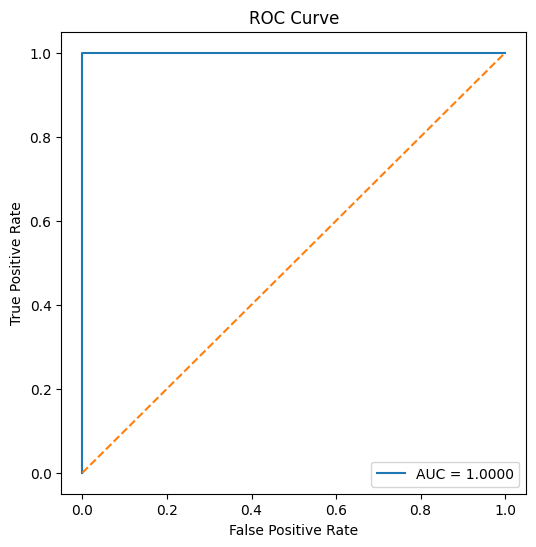

In [34]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc_val = roc_auc_score(y_test, y_prob)

print("Confusion Matrix:\n", cm)
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1       : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc_val:.4f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))


# ===============================
# CONFUSION MATRIX (IMSHOW)
# ===============================
plt.figure(figsize=(5,4))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.xticks([0, 1], ["Pred 0", "Pred 1"])
plt.yticks([0, 1], ["True 0", "True 1"])

for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


# ===============================
# ROC CURVE
# ===============================
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc2 = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc2:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


## 10) Feature Importance (WAJIB TA-14)

Instruksi TA-14: gunakan `plot_importance` dari library `xgboost` dan tampilkan grafik batang.
Setelah plot, tuliskan analisis di laporan: apakah fitur dominan masuk akal secara logika medis/bisnis.


<Figure size 1000x600 with 0 Axes>

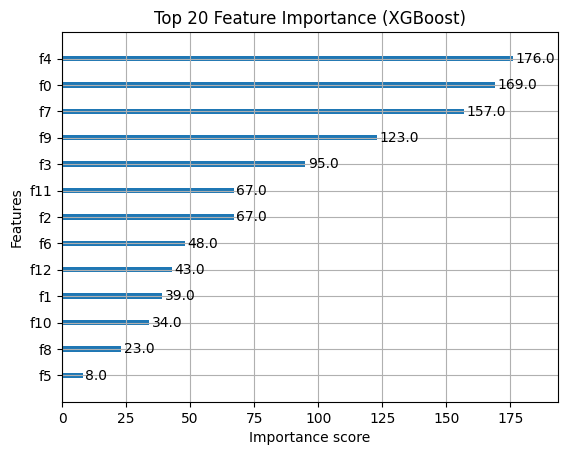

In [35]:

xgb_fitted = model.named_steps["clf"]

plt.figure(figsize=(10,6))
plot_importance(xgb_fitted, max_num_features=20)
plt.title("Top 20 Feature Importance (XGBoost)")
plt.show()


## 11) (Opsional/Bonus) Tuning Sederhana (TA-14: Opsional/Bonus)

TA-14 menyarankan mencoba `max_depth` dan/atau `learning_rate` untuk melihat dampaknya.
Di sini disediakan contoh tuning kecil (boleh di-skip jika tidak diperlukan).


In [36]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    "clf__max_depth": [3, 4, 5],
    "clf__learning_rate": [0.01, 0.05, 0.1],
    "clf__n_estimators": [100, 300, 600]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            eval_metric="auc",
            n_jobs=-1,
            random_state=42,
            scale_pos_weight=scale_pos_weight if is_imbalanced else 1.0
        ))
    ]),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best ROC-AUC:", grid.best_score_)
print("Best Params :", grid.best_params_)


Best ROC-AUC: 0.9945833333333333
Best Params : {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 600}
